# Packages

In [1]:
from pathlib import Path
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data Loading

In [2]:
symbols = ['MSFT', 'PG', 'JPM', 'JNJ', 'DIS', 'KO', 'NKE', 'CAT', 'DD', 'CSX', 'AMD', 'COST', 'WM', 'PFE', 'AIG']
root_folder = Path('.')
data_folder = root_folder / 'data'

In [3]:
if not data_folder.exists():
    data_folder.mkdir()

In [4]:
API_KEY = 'JX7AROJOYXZ74VN4'
datatype = 'csv'

In [34]:
get_symbol_data('US1Y', 'TIME_SERIES_DAILY', override=True)

downloading data for US1Y...
downloaded data for US1Y.


In [5]:
def get_symbol_data(symbol, api_call='TIME_SERIES_DAILY_ADJUSTED', override=False):
    print(f'downloading data for {symbol}...')
    req_url = f'https://www.alphavantage.co/query?function={api_call}&symbol={symbol}&apikey={API_KEY}&datatype={datatype}&outputsize=full'
    symbol_file = data_folder / f'{symbol}_adj.csv'
    if not symbol_file.exists() or override:
        r = requests.get(req_url)
        with symbol_file.open('w') as file:
            file.write(r.text)
    else:
        print(f'{symbol} already exists')
        return
    print(f'downloaded data for {symbol}.')

In [6]:
for s in symbols:
    get_symbol_data(s)

downloading data for MSFT...
MSFT already exists
downloading data for PG...
PG already exists
downloading data for JPM...
JPM already exists
downloading data for JNJ...
JNJ already exists
downloading data for DIS...
DIS already exists
downloading data for KO...
KO already exists
downloading data for NKE...
NKE already exists
downloading data for CAT...
CAT already exists
downloading data for DD...
DD already exists
downloading data for CSX...
CSX already exists
downloading data for AMD...
AMD already exists
downloading data for COST...
COST already exists
downloading data for WM...
WM already exists
downloading data for PFE...
PFE already exists
downloading data for AIG...
AIG already exists


In [7]:
benchmark_symbol = 'SPX'
get_symbol_data(benchmark_symbol)

downloading data for SPX...
SPX already exists


# Data Explore

In [8]:
def load_and_clean_data(symbol, column='close'):
    df = pd.read_csv(data_folder / f'{symbol}.csv')
    cols_to_drop = [c for c in df.columns if c !=column]
    rename_map = {column:symbol}
    return (df.assign(date=lambda x:pd.to_datetime(x['timestamp'], format='%Y-%m-%d'))
              .drop(columns=cols_to_drop)
              .rename(columns=rename_map)
              .set_index('date')
            )

In [9]:
dfs = [load_and_clean_data(f'{s}_adj', 'adjusted_close') for s in symbols]

In [10]:
df = pd.concat(dfs, axis=1).dropna()

In [11]:
df.columns = pd.Series(df.columns).str[:-4]

In [12]:
df.loc['2010-01-01':'2015-01-01', 'COST'].mean()

77.31526327503975

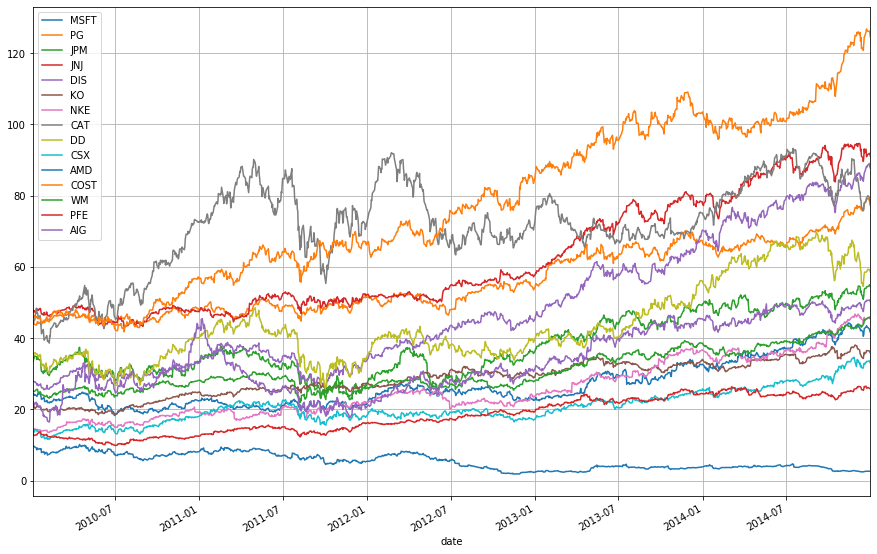

In [13]:
df.loc['2010-01-01':'2015-01-01', :].plot(figsize=(15,10), grid=True)

In [14]:
def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
       return v
    return v / norm

def normalized_df(df):
    normalized_values = normalize(df.values)
    return pd.DataFrame(data=normalized_values, index=df.index, columns=df.columns)

def standardize(df):
    return (df - df.mean()) / df.std()

In [15]:
df_5yr_slice = df.loc['2010-01-01':'2015-01-01', :]
df_5yr_slice_norm = normalized_df(df_5yr_slice)

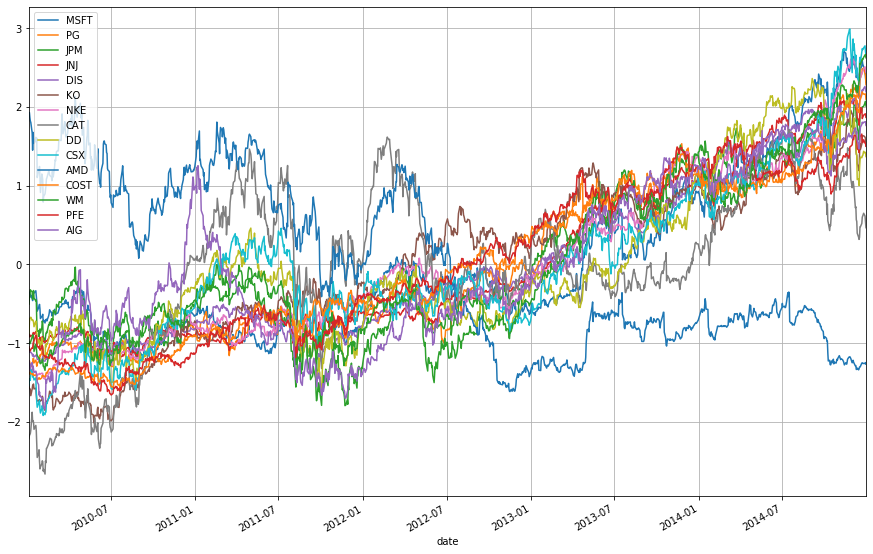

In [16]:
standardize(df_5yr_slice).plot(figsize=(15,10), grid=True)

# Equal Weights

In [17]:
w = 1 / len(df.columns)

In [18]:
def calculate_returns(df):
    return df.sort_index() / df.sort_index().shift(1) - 1

In [19]:
df_returns = calculate_returns(df_5yr_slice)

In [20]:
df_pnl = (df_returns + 1).cumprod()

In [21]:
port_return = (df_pnl.sum(axis=1) / 15)

In [22]:
benchmark_df = load_and_clean_data('SPX_adj', 'adjusted_close')

In [23]:
benchmark_5y_slice = benchmark_df.sort_index().loc['2010-01-01':'2015-01-01', :].rename(columns={'SPX_adj':'SPX'})

In [24]:
benchmark_returns = calculate_returns(benchmark_5y_slice)

In [25]:
benchmark_pnl = (benchmark_returns + 1).cumprod()

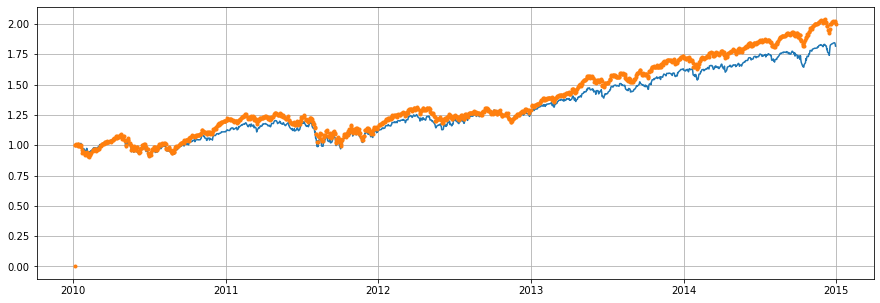

In [26]:
plt.figure(figsize=(15,5))
plt.plot(benchmark_pnl.index, benchmark_pnl['SPX'], '-')
plt.plot(port_return.index, port_return, '.')
plt.grid()

In [27]:
df_5yr_slice.describe()

,MSFT,PG,JPM,JNJ,DIS,KO,NKE,CAT,DD,CSX,AMD,COST,WM,PFE,AIG
count,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000
mean,26.661087,55.850864,37.718378,61.788491,47.998525,28.460441,25.431259,71.871412,43.408982,20.614172,5.436879,77.315263,30.746856,18.209152,33.703516
std,6.510348,9.393448,8.349761,15.733005,18.158538,4.916953,8.174742,12.495086,11.125982,4.692365,2.215261,22.576007,5.668734,5.024168,9.381170
min,18.278200,43.652600,22.744400,42.916900,25.537500,18.553200,13.523300,38.605400,25.557396,11.612900,1.860000,41.777800,21.917800,9.877200,16.466000
25%,21.712525,47.856700,30.857500,48.648150,32.283175,24.970725,18.862225,67.243525,35.485273,17.653850,3.690000,58.742550,26.259100,13.621825,26.296925
50%,24.406950,52.106300,35.210250,54.557400,42.484300,29.616600,22.745550,72.001900,40.492227,19.711400,4.860000,74.846950,28.381600,17.212350,31.055850
75%,30.143475,65.024550,45.808450,76.367475,60.638250,32.595175,32.953425,80.975525,48.826982,23.198625,7.497750,99.226125,35.565500,23.188575,43.293050
max,44.258500,79.293400,55.008600,94.617800,89.014900,38.080500,46.760700,93.259900,69.671501,34.640800,10.160000,126.775400,45.851400,26.523200,50.707100


# MVO

In [107]:
from datetime import datetime
import scipy.optimize as sco

In [76]:
def get_n_year_slice(df, ref_year, n):
    ref_dt = datetime(ref_year, 1, 1)
    start_dt = datetime(ref_year-n, 1, 1)
    
    first_dt = df.index.min()
    date_format = '%Y-%m-%d'
    if start_dt < first_dt:
        print(f'''{start_dt.strftime(date_format)} is less than first date of df: {first_dt.strftime(date_format)}''')
    
    return df.loc[start_dt:ref_dt, :]

In [98]:
px_data_map = {}
bn_data_map = {}
for i in [2015,2016,2017, 2018]:
    px_data_map[i] = get_n_year_slice(df.sort_index(), i, 5)
    bn_data_map[i] = get_n_year_slice(benchmark_df.sort_index(), i, 5)
    

In [311]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate, rtns, bm_rtns):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
                   {'type': 'ineq', 'fun': lambda x: 0.08 - tracking_error_constraint(x, rtns, bm_rtns)})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [312]:
def tracking_error_constraint(x, returns, bm_returns):
    tmp = pd.concat([returns.dropna().dot(x), bm_returns.dropna()], axis=1).rename(columns={0:'port_rtn'})
    tmp = tmp.assign(tracking_error=lambda x:x['port_rtn'] - x['SPX_adj'])
    return tmp['tracking_error'].std() * np.sqrt(252)

In [313]:
returns = px_data_map[2015].pct_change()
bm_rtns = bn_data_map[2015].pct_change()
cov_matrix = returns.cov()

In [314]:
result = max_sharpe_ratio(returns.mean(), cov_matrix, 0.02, returns, bm_rtns)

In [315]:
pd.options.display.float_format = '{:.6f}%'.format

In [316]:
tracking_error_constraint(result.x, returns, bm_rtns)

0.08000016865393653

In [317]:
wgts_df = pd.DataFrame(result.x, index=returns.columns).T

In [263]:
port_rtn_df =returns.dropna().dot(wgts_df.T).rename(columns={0:'port_rtn'})

In [321]:
(wgts_df*100).sum(axis=1)

0   100.000000%
dtype: float64